In [247]:
import warnings
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model, preprocessing
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error, r2_score

from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution

In [248]:
def generate_data(weeks):
  df = pd.read_csv(f'../data/balaios/grupo_{weeks}.csv')
  # Não fica bom remover os casos onde não houveram tweets. piora em todos os balaios e todos os modelos
  # df = df.round(decimals=2)
  # df = df[~(df == 0.00).any(axis=1)]

  #x = semana + tweets na semana
  x_data = []
  tweets = np.array(df['tweets na semana'])

  i = 0
  for week in np.array(pd.to_numeric(df['semana'])):
    x_data.append([week, tweets[i]])
    i += 1

  #y = casos de covid na semana
  y_data = np.array(df['casos de covid na semana'])

  return x_data, y_data

def generate_linear_model(weeks):
  x_data, y_data = generate_data(weeks)

  reg = linear_model.LinearRegression().fit(x_data, y_data)
  print(f"Regressão linear. score: {reg.score(x_data, y_data)}")

  return reg, reg.score(x_data, y_data)

- São Paulo - casos de 4 semanas depois refletem os tweets dessa semana com 0.692619 corr
- Rio de Janeiro - casos de 4 semanas depois refletem os tweets dessa semana com -0.604875 corr
- Belo Horizonte - casos de 1 semana depois refletem os tweets dessa semana com 0.61064 corr
- Fortaleza - casos de 2 semanas depois refletem os tweets dessa semana com 0.631897 corr
- Porto Alegre - casos de 3 semanas depois refletem os tweets dessa semana com -0.617216 corr
- Recife - casos de 3 semanas depois refletem os tweets dessa semana com 0.579416 corr
- Manaus - casos de 4 semanas depois refletem os tweets dessa semana com -0.408583 corr
- Salvador - casos de 2 semanas depois refletem os tweets dessa semana com -0.326249 corr

In [249]:
zero, zero_score = generate_linear_model(0)
one, one_score = generate_linear_model(1)
two, two_score = generate_linear_model(2)
three, three_score = generate_linear_model(3)
four, four_score = generate_linear_model(4)

Regressão linear. score: 0.7051150025040613
Regressão linear. score: 0.6529075338706418
Regressão linear. score: 0.4198082740084118
Regressão linear. score: 0.5037022076532327
Regressão linear. score: 0.5780725804937276


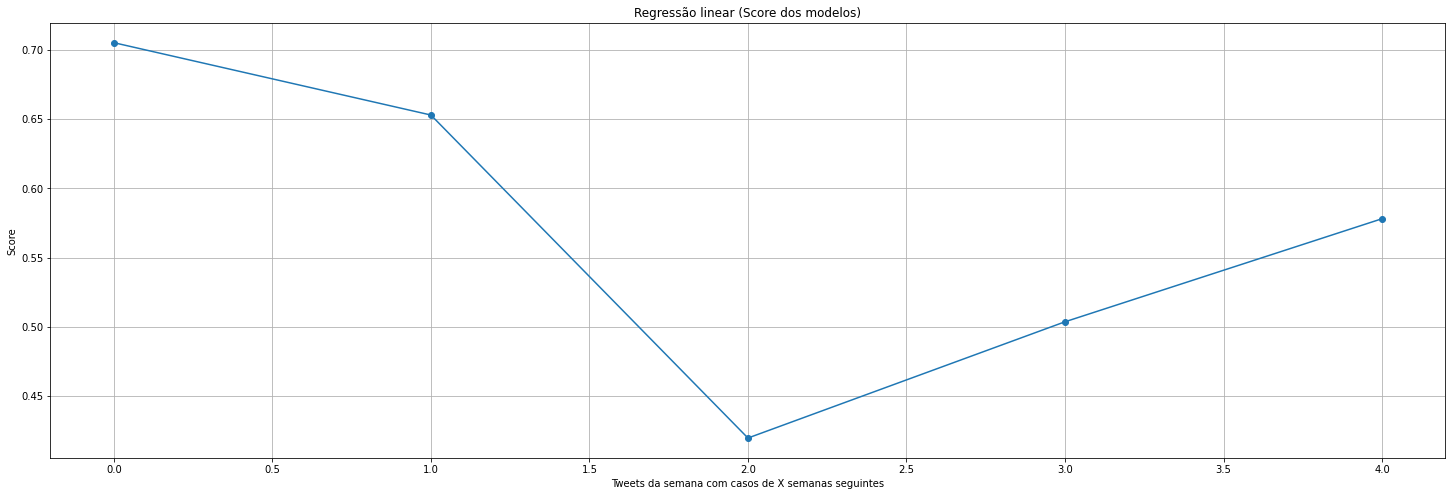

In [250]:
x = [0, 1, 2, 3, 4]
y = [zero_score, one_score, two_score, three_score, four_score]

fig, ax = plt.subplots(figsize=(25, 8))
ax.plot(x, y, marker='o')

ax.set(xlabel='Tweets da semana com casos de X semanas seguintes', ylabel='Score', title='Regressão linear (Score dos modelos)')
ax.grid()

plt.show()

In [251]:
#teste pontual para tentativa de próximas semanas
one.predict(np.array([[35, 0.05]]))

array([0.35386042])

In [252]:
def generate_exp_model(weeks):
    def func(x, a, b, Offset): # Sigmoid A With Offset from zunzun.com
        return  1.0 / (1.0 + np.exp(-a * (x-b))) + Offset


    # function for genetic algorithm to minimize (sum of squared error)
    def sumOfSquaredError(parameterTuple):
        warnings.filterwarnings("ignore") # do not print warnings by genetic algorithm
        val = func(x_data, *parameterTuple)
        return np.sum((y_data - val) ** 2.0)


    def generate_Initial_Parameters():
        # min and max used for bounds
        maxX = max(x_data)
        minX = min(x_data)
        maxY = max(y_data)
        minY = min(y_data)

        parameterBounds = []
        parameterBounds.append([minX, maxX]) # search bounds for a
        parameterBounds.append([minX, maxX]) # search bounds for b
        parameterBounds.append([0.0, maxY]) # search bounds for Offset

        # "seed" the np random number generator for repeatable results
        result = differential_evolution(sumOfSquaredError, parameterBounds, seed=3)
        return result.x

    # graphics output section
    def ModelAndScatterPlot(graphWidth, graphHeight, fittedParameters, RMSE, Rsquared, week):
        f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
        axes = f.add_subplot(111)

        # first the raw data as a scatter plot
        axes.plot(x_data, y_data, 'D')

        # create data for the fitted equation plot
        xModel = np.linspace(min(x_data), max(x_data))
        yModel = func(xModel, *fittedParameters)

        # now the model as a line plot 
        axes.plot(xModel, yModel)

        axes.set_xlabel('Tweets na semana') # X axis data label
        axes.set_ylabel('Casos de covid na semana') # Y axis data label
        axes.set_title(f'Curva encontrada - {week}')
        plt.text(-0.05, 0.2, f'Parâmetros: {str(fittedParameters)}\nRMSE: {str(RMSE)}\nR^2: {str(Rsquared)}', horizontalalignment='left',
            verticalalignment='center', transform=ax.transAxes, bbox=dict(facecolor='red', alpha=0.5))

        plt.show()
        plt.close('all') # clean up after using pyplot

    df = pd.read_csv(f'../data/balaios/grupo_{weeks}.csv')
    x_data = np.array(df['tweets na semana'])
    y_data = np.array(df['casos de covid na semana'])

    # generate initial parameter values
    geneticParameters = generate_Initial_Parameters()

    # curve fit the test data
    fittedParameters, pcov = curve_fit(func, x_data, y_data, geneticParameters)

    print('Parameters', fittedParameters)

    modelPredictions = func(x_data, *fittedParameters) 

    absError = modelPredictions - y_data

    SE = np.square(absError) # squared errors
    MSE = np.mean(SE) # mean squared errors
    RMSE = np.sqrt(MSE) # Root Mean Squared Error, RMSE
    Rsquared = 1.0 - (np.var(absError) / np.var(y_data))

    print('RMSE:', RMSE)
    print('R-squared:', Rsquared)

    graphWidth = 800
    graphHeight = 600
    ModelAndScatterPlot(graphWidth, graphHeight, fittedParameters, RMSE, Rsquared, weeks)
    return Rsquared


Parameters [4.21710145 0.68038548 0.20228442]
RMSE: 0.13894044393931707
R-squared: 0.6709672251114478


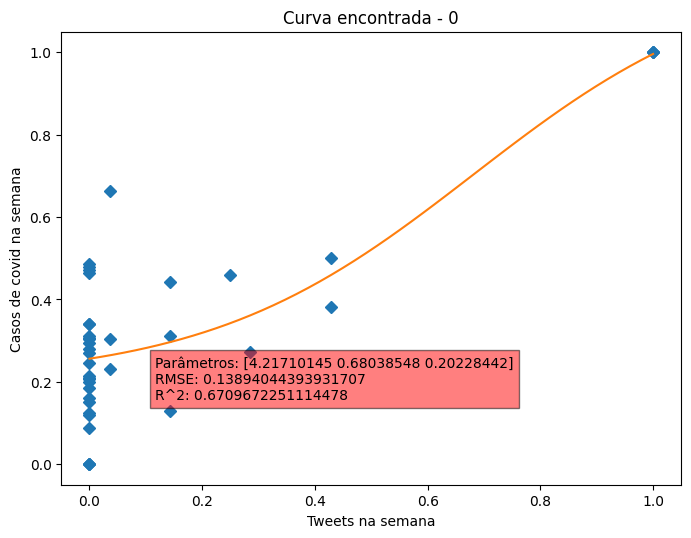

Parameters [3.2356006  0.42971603 0.07508495]
RMSE: 0.18777525426618677
R-squared: 0.6196213235812847


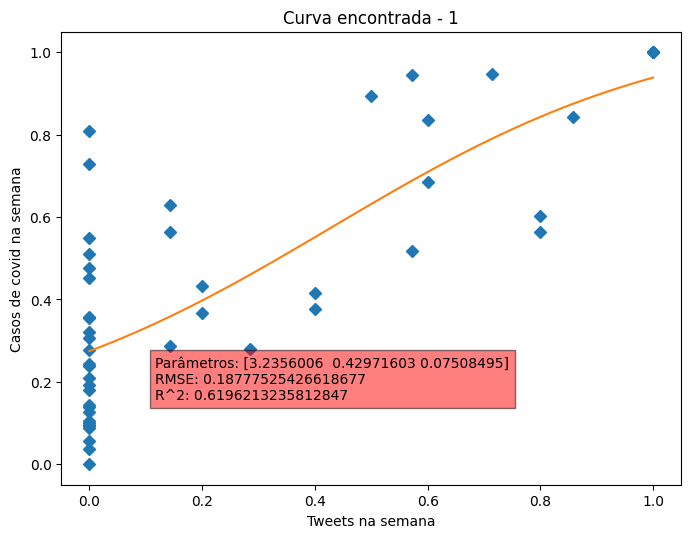

Parameters [1.42723459 1.14820236 0.34607831]
RMSE: 0.1407091074614343
R-squared: 0.4202403010260489


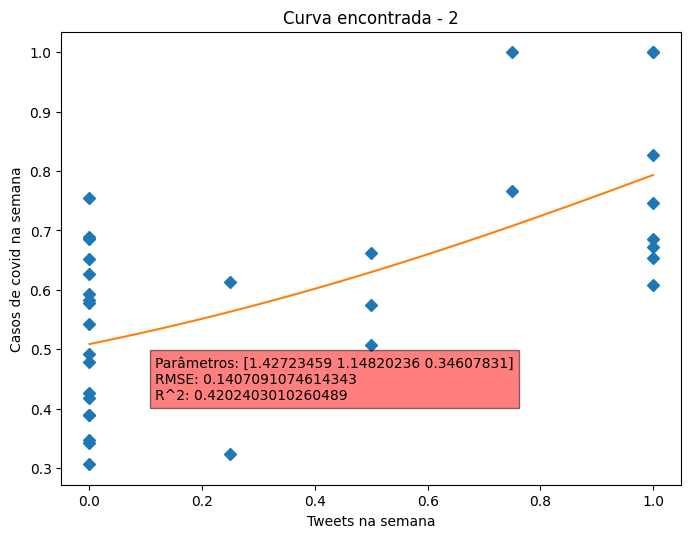

Parameters [2.47468667 0.75493018 0.27859476]
RMSE: 0.18421035214147005
R-squared: 0.4887811857725357


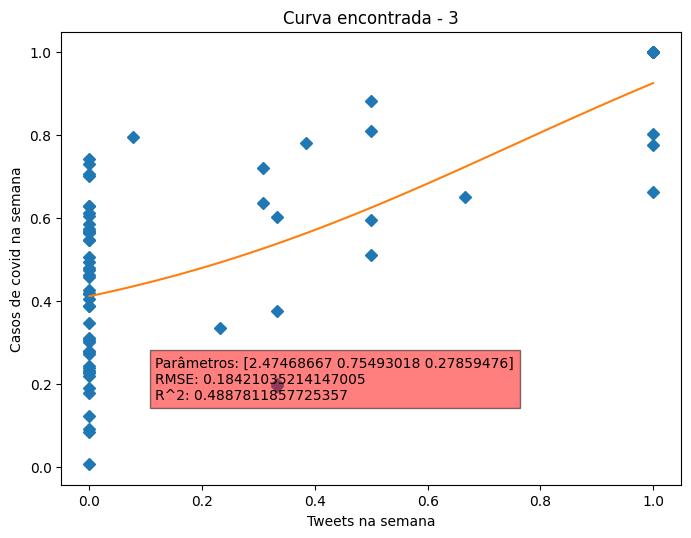

Parameters [ 5.6186959   0.03774144 -0.06836058]
RMSE: 0.16232318556347855
R-squared: 0.619596419588931


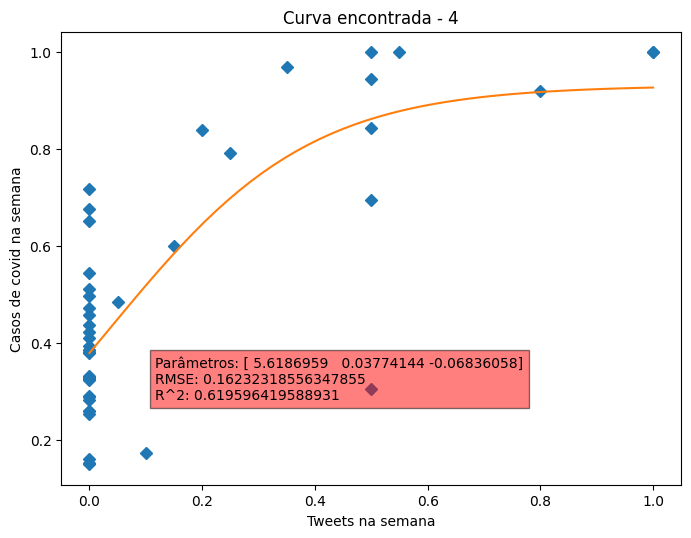

In [253]:
zero_exp = generate_exp_model(0)
one_exp = generate_exp_model(1)
two_exp = generate_exp_model(2)
three_exp = generate_exp_model(3)
four_exp = generate_exp_model(4)

y_exp = [zero_exp, one_exp, two_exp, three_exp, four_exp]

In [254]:
def generate_logistic_model(weeks):
  x_data, y_data = generate_data(weeks)

  lab_enc = preprocessing.LabelEncoder()
  y_data = lab_enc.fit_transform(y_data)

  reg = linear_model.LogisticRegression().fit(x_data, y_data)
  print(f"Regressão logística. score: {reg.score(x_data, y_data)}") 

  return reg, reg.score(x_data, y_data)

zero, zero_logistic = generate_logistic_model(0)
one, one_logistic = generate_logistic_model(1)
two, two_logistic = generate_logistic_model(2)
three, three_logistic = generate_logistic_model(3)
four, four_logistic = generate_logistic_model(4)

Regressão logística. score: 0.3333333333333333
Regressão logística. score: 0.25
Regressão logística. score: 0.21212121212121213
Regressão logística. score: 0.11428571428571428
Regressão logística. score: 0.2222222222222222


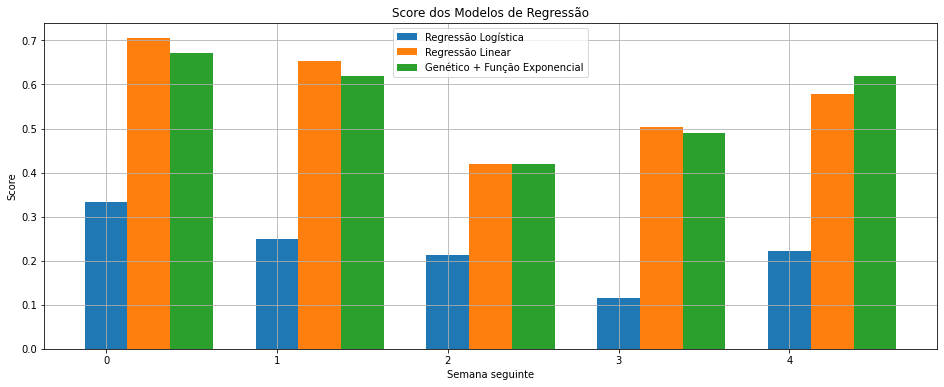

In [255]:
y_logistic = [zero_logistic, one_logistic, two_logistic, three_logistic, four_logistic]
width = 0.25

fig, ax = plt.subplots(figsize=(16, 6))

X_axis = np.arange(len(x))

ax.bar(X_axis, y_logistic, width, label="Regressão Logística")
ax.bar(X_axis + width, y, width, label="Regressão Linear")
ax.bar(X_axis + width*2, y_exp, width, label="Genético + Função Exponencial")

plt.xticks(X_axis, x)
ax.set(xlabel='Semana seguinte', ylabel='Score', title='Score dos Modelos de Regressão')
ax.legend()
ax.grid()

plt.show()

In [256]:
#teste pontual para tentativa de próximas semanas
one.predict(np.array([[35, 0.05]]))

array([9])